In [84]:
from __future__ import division
from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans

In [85]:
import plotly.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import Layout, Figure, Pie, Bar

In [86]:
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [87]:
import types
from botocore.client import Config
import ibm_boto3
init_notebook_mode(connected=True)


In [88]:
tx_data = pd.read_csv(body)
tx_data.head()

,order_id,client_id,service_id,gift_id,gift_cost,total_gifts,total_amount,fee,variable_cost,total_revenue,month,year,date
0,11110,419,1,16,1289.54,13,16764,3352.8,4326,20116.8,3,2018,3-2018
1,11111,503,3,21,235.66,50,11783,2356.6,5976,14139.6,10,2019,10-2019
2,11112,395,2,23,211.97,71,15050,3010.0,4836,18060.0,3,2019,3-2019
3,11113,292,1,22,445.24,38,16919,3383.8,6144,20302.8,6,2019,6-2019
4,11114,408,1,14,1247.91,11,13727,2745.4,5632,16472.4,4,2018,4-2018


In [89]:
tx_data['BillDate'] = pd.to_datetime(tx_data['date'])

In [90]:
tx_data['BillDate'].describe()

count                    3999
unique                     24
top       2019-08-01 00:00:00
freq                      187
first     2018-01-01 00:00:00
last      2019-12-01 00:00:00
Name: BillDate, dtype: object

In [91]:
tx_3m = tx_data[(tx_data.BillDate < date(2019,6,1)) & (tx_data.BillDate >= date(2019,3,1))].reset_index(drop=True)
tx_6m = tx_data[(tx_data.BillDate >= date(2019,6,1)) & (tx_data.BillDate < date(2019,12,1))].reset_index(drop=True)

In [92]:
tx_3m['BillDate'].describe()

count                     518
unique                      3
top       2019-03-01 00:00:00
freq                      182
first     2019-03-01 00:00:00
last      2019-05-01 00:00:00
Name: BillDate, dtype: object

In [93]:
tx_user = pd.DataFrame(tx_3m['client_id'].unique())
tx_user.columns = ['client_id']

# Recency

In [94]:
tx_max_purchase = tx_3m.groupby('client_id').BillDate.max().reset_index()

In [95]:
tx_max_purchase.columns = ['client_id','MaxPurchaseDate']

In [96]:
tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days

In [97]:
tx_user = pd.merge(tx_user, tx_max_purchase[['client_id','Recency']], on='client_id')

In [98]:
tx_user.head()

,client_id,Recency
0,395,0
1,178,61
2,434,30
3,289,61
4,254,61


In [99]:
tx_user.Recency.describe()

count    311.000000
mean      23.090032
std       24.355001
min        0.000000
25%        0.000000
50%       30.000000
75%       30.000000
max       61.000000
Name: Recency, dtype: float64

In [100]:
plot_data = [
    go.Histogram(
        x=tx_user['Recency']
    )
]

plot_layout = go.Layout(
        title='Recency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

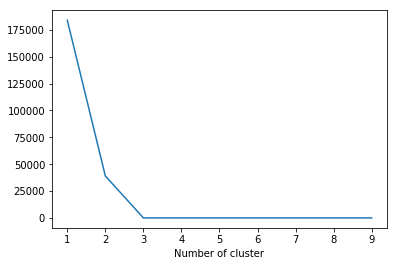

In [101]:
sse={}
tx_recency = tx_user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Recency']])
tx_user['RecencyCluster'] = kmeans.predict(tx_user[['Recency']])

In [ ]:
tx_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,71.0,61.0,0.0,61.0,61.0,61.0,61.0,61.0
2,95.0,30.0,0.0,30.0,30.0,30.0,30.0,30.0
3,145.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [ ]:
tx_user = order_cluster('RecencyCluster', 'Recency',tx_user,False)

# Frequency

In [ ]:
tx_frequency = tx_3m.groupby('client_id').BillDate.count().reset_index()

In [ ]:
tx_frequency.columns = ['client_id','Frequency']

In [ ]:
tx_frequency.head()

,client_id,Frequency
0,111,1
1,113,1
2,115,2
3,117,1
4,119,1


In [ ]:
tx_user = pd.merge(tx_user, tx_frequency, on='client_id')

In [ ]:
tx_user.head()

,client_id,Recency,RecencyCluster,Frequency
0,395,0,2,3
1,277,0,2,1
2,387,0,2,3
3,397,0,2,1
4,201,0,2,3


In [ ]:
tx_user.Frequency.describe()

count    311.000000
mean       1.665595
std        0.852363
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        5.000000
Name: Frequency, dtype: float64

In [ ]:
plot_data = [
    go.Histogram(
        x=tx_user.query('Frequency < 1000')['Frequency']
    )
]

plot_layout = go.Layout(
        title='Frequency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

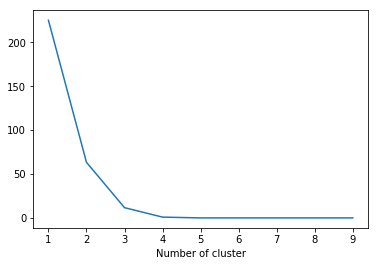

In [ ]:
sse={}
tx_frequency = tx_user[['Frequency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_frequency)
    tx_frequency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Frequency']])
tx_user['FrequencyCluster'] = kmeans.predict(tx_user[['Frequency']])

In [ ]:
tx_user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,92.0,2.000000,0.000000,2.0,2.0,2.0,2.0,2.0
1,168.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
2,39.0,3.000000,0.000000,3.0,3.0,3.0,3.0,3.0
3,12.0,4.083333,0.288675,4.0,4.0,4.0,4.0,5.0


In [ ]:
tx_user = order_cluster('FrequencyCluster', 'Frequency',tx_user,True)

# Monetary Value

In [ ]:
tx_3m['Revenue'] = tx_3m['total_revenue'] * tx_3m['total_gifts']

In [ ]:
tx_revenue = tx_3m.groupby('client_id').Revenue.sum().reset_index()

In [ ]:
tx_revenue.head()

,client_id,Revenue
0,111,572146.8
1,113,219744.0
2,115,1728891.6
3,117,924283.2
4,119,313038.0


In [ ]:
tx_user = pd.merge(tx_user, tx_revenue, on='client_id')

In [ ]:
tx_user.Revenue.describe()

count    3.110000e+02
mean     1.362399e+06
std      9.076217e+05
min      1.639008e+05
25%      6.755796e+05
50%      1.148906e+06
75%      1.821838e+06
max      5.472004e+06
Name: Revenue, dtype: float64

In [ ]:
plot_data = [
    go.Histogram(
        x=tx_user.query('Revenue < 1000000')['Revenue']
    )
]

plot_layout = go.Layout(
        title='Monetary Value'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

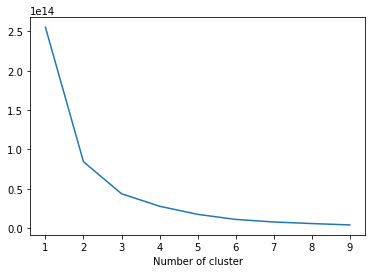

In [ ]:
sse={}
tx_revenue = tx_user[['Revenue']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_revenue)
    tx_revenue["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Revenue']])
tx_user['RevenueCluster'] = kmeans.predict(tx_user[['Revenue']])

In [ ]:
tx_user = order_cluster('RevenueCluster', 'Revenue',tx_user,True)

In [ ]:
tx_user.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,114.0,5.506634e+05,212366.844177,163900.8,361421.4,585195.0,716273.1,895804.8
1,108.0,1.254388e+06,227586.339396,909838.8,1044876.0,1238630.4,1414852.2,1699272.0
2,65.0,2.187330e+06,339444.370061,1728708.0,1856704.8,2184228.0,2443008.0,2820312.0
3,24.0,3.470001e+06,664015.785574,2850184.8,3004179.3,3327292.2,3554468.4,5472003.6


# Overall Segmentation

In [ ]:
tx_user.head()

,client_id,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
0,395,0,2,3,2,2092231.2,2
1,439,0,2,3,2,2380378.8,2
2,196,0,2,3,2,2004301.2,2
3,386,0,2,3,2,2214000.0,2
4,452,0,2,3,2,2476008.0,2


In [ ]:
tx_user['OverallScore'] = tx_user['RecencyCluster'] + tx_user['FrequencyCluster'] + tx_user['RevenueCluster']

In [ ]:
tx_user.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()

,Recency,Frequency,Revenue
OverallScore,,,
0,61.000000,1.000000,5.386522e+05
1,43.372549,1.000000,8.192011e+05
2,17.162162,1.162162,8.219983e+05
3,17.086957,1.543478,1.288218e+06
4,14.210526,2.052632,1.717479e+06
5,8.888889,2.370370,2.067782e+06
6,3.750000,2.958333,2.418362e+06
7,2.727273,3.181818,3.229313e+06
8,0.000000,4.142857,4.201124e+06


In [ ]:
tx_user.groupby('OverallScore')['Recency'].count()

OverallScore
0    33
1    51
2    74
3    46
4    38
5    27
6    24
7    11
8     7
Name: Recency, dtype: int64

In [ ]:
tx_user['Segment'] = 'Low-Value'
tx_user.loc[tx_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
tx_user.loc[tx_user['OverallScore']>4,'Segment'] = 'High-Value'

In [ ]:
tx_graph = tx_user.query("Revenue < 1000000 and Frequency < 20000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'Low-Value'")['Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'High-Value'")['Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Frequency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [ ]:
tx_graph = tx_user.query("Revenue < 1000000 and Frequency < 20000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Low-Value'")['Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['Recency'],
        y=tx_graph.query("Segment == 'High-Value'")['Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [ ]:
tx_graph = tx_user.query("Revenue < 1000000 and Frequency < 20000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Low-Value'")['Frequency'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['Frequency'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['Recency'],
        y=tx_graph.query("Segment == 'High-Value'")['Frequency'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Frequency"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

# LTV

In [ ]:
tx_user.head()

,client_id,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,395,0,2,3,2,2092231.2,2,6,High-Value
1,439,0,2,3,2,2380378.8,2,6,High-Value
2,196,0,2,3,2,2004301.2,2,6,High-Value
3,386,0,2,3,2,2214000.0,2,6,High-Value
4,452,0,2,3,2,2476008.0,2,6,High-Value


In [ ]:
tx_6m.head()

,order_id,client_id,service_id,gift_id,gift_cost,total_gifts,total_amount,fee,variable_cost,total_revenue,month,year,date,BillDate
0,11111,503,3,21,235.66,50,11783,2356.6,5976,14139.6,10,2019,10-2019,2019-10-01
1,11113,292,1,22,445.24,38,16919,3383.8,6144,20302.8,6,2019,6-2019,2019-06-01
2,11117,207,3,17,260.98,40,10439,2087.8,5544,12526.8,8,2019,8-2019,2019-08-01
3,11118,481,3,16,162.03,63,10208,2041.6,5148,12249.6,9,2019,9-2019,2019-09-01
4,11120,502,3,23,624.22,27,16854,3370.8,6546,20224.8,11,2019,11-2019,2019-11-01


In [ ]:
tx_6m['Revenue'] = tx_6m['total_revenue'] * tx_6m['total_gifts']

In [ ]:
tx_user_6m = tx_6m.groupby('client_id')['Revenue'].sum().reset_index()
tx_user_6m.columns = ['client_id','m6_Revenue']

In [ ]:
tx_6m.head()

,order_id,client_id,service_id,gift_id,gift_cost,total_gifts,total_amount,fee,variable_cost,total_revenue,month,year,date,BillDate,Revenue
0,11111,503,3,21,235.66,50,11783,2356.6,5976,14139.6,10,2019,10-2019,2019-10-01,706980.0
1,11113,292,1,22,445.24,38,16919,3383.8,6144,20302.8,6,2019,6-2019,2019-06-01,771506.4
2,11117,207,3,17,260.98,40,10439,2087.8,5544,12526.8,8,2019,8-2019,2019-08-01,501072.0
3,11118,481,3,16,162.03,63,10208,2041.6,5148,12249.6,9,2019,9-2019,2019-09-01,771724.8
4,11120,502,3,23,624.22,27,16854,3370.8,6546,20224.8,11,2019,11-2019,2019-11-01,546069.6


In [ ]:
plot_data = [
    go.Histogram(
        x=tx_user_6m.query('m6_Revenue < 1000000')['m6_Revenue']
    )
]

plot_layout = go.Layout(
        title='6m Revenue'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)


In [ ]:
tx_merge = pd.merge(tx_user, tx_user_6m, on='client_id', how='left')

In [ ]:
tx_merge.head()

,client_id,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m6_Revenue
0,395,0,2,3,2,2092231.2,2,6,High-Value,NaN
1,439,0,2,3,2,2380378.8,2,6,High-Value,507471.6
2,196,0,2,3,2,2004301.2,2,6,High-Value,1571794.8
3,386,0,2,3,2,2214000.0,2,6,High-Value,NaN
4,452,0,2,3,2,2476008.0,2,6,High-Value,2002999.2


In [ ]:
tx_merge = tx_merge.fillna(0)

In [ ]:
tx_merge.groupby('Segment')['m6_Revenue'].mean()

Segment
High-Value    1.786412e+06
Low-Value     2.005848e+06
Mid-Value     2.073955e+06
Name: m6_Revenue, dtype: float64

In [ ]:
tx_graph = tx_merge.query("m6_Revenue < 3000000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['OverallScore'],
        y=tx_graph.query("Segment == 'Low-Value'")['m6_Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['OverallScore'],
        y=tx_graph.query("Segment == 'Mid-Value'")['m6_Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['OverallScore'],
        y=tx_graph.query("Segment == 'High-Value'")['m6_Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "6m LTV"},
        xaxis= {'title': "RFM Score"},
        title='LTV'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [ ]:
tx_merge = tx_merge[tx_merge['m6_Revenue']<tx_merge['m6_Revenue'].quantile(0.99)]

In [ ]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(tx_merge[['m6_Revenue']])
tx_merge['LTVCluster'] = kmeans.predict(tx_merge[['m6_Revenue']])

In [ ]:
tx_merge = order_cluster('LTVCluster', 'm6_Revenue',tx_merge,True)

In [ ]:
tx_merge.groupby('LTVCluster')['m6_Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,124.0,7.081012e+05,445517.688471,0.0,362669.4,775430.4,1114269.9,1381489.2
1,116.0,2.073393e+06,430123.402483,1391766.0,1688370.6,2037915.0,2434632.9,2895204.0
2,67.0,3.883364e+06,689066.273862,3013020.0,3327408.0,3686258.4,4301803.8,5401839.6


In [ ]:
tx_cluster = tx_merge.copy()

In [ ]:
tx_cluster.head()

,client_id,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m6_Revenue,LTVCluster
0,395,0,2,3,2,2092231.2,2,6,High-Value,0.0,0
1,439,0,2,3,2,2380378.8,2,6,High-Value,507471.6,0
2,386,0,2,3,2,2214000.0,2,6,High-Value,0.0,0
3,198,0,2,3,2,2449724.4,2,6,High-Value,1289830.8,0
4,340,0,2,3,2,2558809.2,2,6,High-Value,507124.8,0


In [ ]:
tx_cluster.groupby('LTVCluster')['m6_Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,124.0,7.081012e+05,445517.688471,0.0,362669.4,775430.4,1114269.9,1381489.2
1,116.0,2.073393e+06,430123.402483,1391766.0,1688370.6,2037915.0,2434632.9,2895204.0
2,67.0,3.883364e+06,689066.273862,3013020.0,3327408.0,3686258.4,4301803.8,5401839.6


In [ ]:
tx_cluster.head()

,client_id,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m6_Revenue,LTVCluster
0,395,0,2,3,2,2092231.2,2,6,High-Value,0.0,0
1,439,0,2,3,2,2380378.8,2,6,High-Value,507471.6,0
2,386,0,2,3,2,2214000.0,2,6,High-Value,0.0,0
3,198,0,2,3,2,2449724.4,2,6,High-Value,1289830.8,0
4,340,0,2,3,2,2558809.2,2,6,High-Value,507124.8,0


In [ ]:
tx_class = pd.get_dummies(tx_cluster)

In [ ]:
tx_class.head()

,client_id,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,m6_Revenue,LTVCluster,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
0,395,0,2,3,2,2092231.2,2,6,0.0,0,1,0,0
1,439,0,2,3,2,2380378.8,2,6,507471.6,0,1,0,0
2,386,0,2,3,2,2214000.0,2,6,0.0,0,1,0,0
3,198,0,2,3,2,2449724.4,2,6,1289830.8,0,1,0,0
4,340,0,2,3,2,2558809.2,2,6,507124.8,0,1,0,0


In [ ]:
corr_matrix = tx_class.corr()
corr_matrix['LTVCluster'].sort_values(ascending=False)

LTVCluster            1.000000
m6_Revenue            0.919400
Segment_Mid-Value     0.080461
Recency               0.007585
Frequency            -0.006591
FrequencyCluster     -0.007625
RecencyCluster       -0.007698
Segment_Low-Value    -0.025802
OverallScore         -0.030088
RevenueCluster       -0.051523
Segment_High-Value   -0.054995
Revenue              -0.057294
client_id            -0.089989
Name: LTVCluster, dtype: float64

In [ ]:
X = tx_class.drop(['LTVCluster','m6_Revenue'],axis=1)
y = tx_class['LTVCluster']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=56)

In [ ]:
ltv_xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.1,objective= 'multi:softprob',n_jobs=-1).fit(X_train, y_train)


In [ ]:
tx_class.groupby('LTVCluster').client_id.count()/tx_class.client_id.count()

In [ ]:
y_pred = ltv_xgb_model.predict(X_test)

In [ ]:
print classification_report(y_test, y_pred)